In [1]:
from sklearn.model_selection import KFold
import json
from collections import Counter
import random
import torch
import torch.nn as nn
from utils import PixelSetEncoder, TimeSeriesTransformer, SimpleMLP, trainer_function,\
    PixelSetData, RandomSamplePixels, Normalize, ToTensor, pad_sequences_collate_fn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import numpy as np

In [2]:
f_labels = open(r"Exercise4\timematch_data\denmark\32VNH\2017\meta\labels_cleaned.json")
labels_200 = json.load(f_labels)

print(len(labels_200), len(set(labels_200.values())))

labels_200_counter = Counter(labels_200.values())

4255 7


In [3]:
# keep random subset of labels
labels_keys = list(labels_200.keys()) # indices 0, 1, 2 ...
labels_subset = random.sample(labels_keys, 150)
labels_subset = {key: labels_200[key] for key in labels_subset}

print(len(labels_subset), len(set(labels_subset.values())))

labels_subset_counter = Counter(labels_subset.values())

150 7


In [4]:
labels_200 = labels_subset
labels_200_counter = labels_subset_counter

num_classes = len(labels_200_counter)

print(num_classes)

class_to_idx = {cls: idx for idx, cls in enumerate(labels_200_counter)}

7


In [5]:
class CompleteModel(nn.Module):
    def __init__(self, pixel_encoder, transformer_encoder, simple_mlp):
        super(CompleteModel, self).__init__()
        self.pixel_encoder = pixel_encoder
        self.transformer_encoder = transformer_encoder
        self.simple_mlp = simple_mlp
    
    def forward(self, x, mask):
        x = self.pixel_encoder(x, mask)  # torch.Size([8, 52, 128])
        x = self.transformer_encoder(x)  # torch.Size([8, 128])
        x = self.simple_mlp(x) # torch.Size([8, 7])
        return x
# model = CompleteModel(pixel_encoder, transformer_encoder, simple_mlp)
# total_params = sum(p.numel() for p in model.parameters())
# print(f"Number of parameters: {total_params}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## K FOLD

In [6]:
# Convert labels to indices
indices = list(labels_200.keys())
kf = KFold(n_splits=3, shuffle=True, random_state=42)

folds = []
for train_idx, val_idx in kf.split(indices):
    train_indices = [indices[i] for i in train_idx]
    val_indices = [indices[i] for i in val_idx]
    folds.append((train_indices, val_indices))

In [7]:
def train_one_fold(device, train_indices, val_indices, data_root, class_to_idx,
                   true_labels, num_epochs=3, train_batch_size=8, val_batch_size=8):
    
    train_transform = transforms.Compose([RandomSamplePixels(32), Normalize(), ToTensor()])
    test_transform = transforms.Compose([Normalize(), ToTensor()])

    train_labels = {}
    val_labels = {}
    for i in train_indices:
        train_labels[i] = true_labels[i]
    for i in val_indices:
        val_labels[i] = true_labels[i]
    
    train_dataset = PixelSetData(data_root, class_to_idx, train_labels, train_transform)
    val_dataset = PixelSetData(data_root, class_to_idx, val_labels, test_transform)
    
    train_dloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, collate_fn=pad_sequences_collate_fn)
    val_dloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False, collate_fn=pad_sequences_collate_fn)
    
    pixel_encoder = PixelSetEncoder(10, mlp1=[10, 32],
                                    pooling="mean_std",
                                    mlp2=[64, 128])
    transformer_encoder = TimeSeriesTransformer(d_model=128)
    simple_mlp = SimpleMLP(input_dim=128, output_dim=7)

    model = CompleteModel(pixel_encoder, transformer_encoder, simple_mlp)
    model = model.to(device)
    
    # return the last score of every fold training and validation metric
    train_losses, train_accuracies, train_f1_micros, train_f1_weighteds,\
        val_losses, val_accuracies, val_f1_micros, val_f1_weighteds,\
        train_precisions, train_recalls, val_precisions, val_recalls = \
            trainer_function(model, num_classes, train_dloader, val_dloader, device, num_epochs=num_epochs)
    
    return train_losses, train_accuracies, train_f1_micros, train_f1_weighteds, val_losses, val_accuracies,\
        val_f1_micros, val_f1_weighteds, train_precisions, train_recalls, val_precisions, val_recalls

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Fold 1/3
Epoch 0/2
----------
Loss: 1.8676 Acc: 0.1800
F1 Micro: 0.1800 F1 Weighted: 0.0924
Precision: 0.1800 Recall: 0.1800
Confusion Matrix:
tensor([[ 1,  0,  0,  0, 20,  1,  4],
        [ 1,  0,  0,  0,  4,  0,  0],
        [ 0,  0,  0,  0,  1,  1,  1],
        [ 2,  0,  0,  0, 11,  0,  2],
        [ 3,  0,  0,  0, 17,  0,  2],
        [ 2,  0,  0,  0, 17,  0,  5],
        [ 1,  0,  0,  0,  4,  0,  0]])
Validation Loss: 1.7745 Acc: 0.3200
Validation F1 Micro: 0.3200 F1 Weighted: 0.1552
Validation Precision: 0.3200 Recall: 0.3200
Validation Confusion Matrix:
tensor([[16,  0,  0,  0,  0,  0,  0],
        [ 4,  0,  0,  0,  0,  0,  0],
        [ 3,  0,  0,  0,  0,  0,  0],
        [ 5,  0,  0,  0,  0,  0,  0],
        [12,  0,  0,  0,  0,  0,  0],


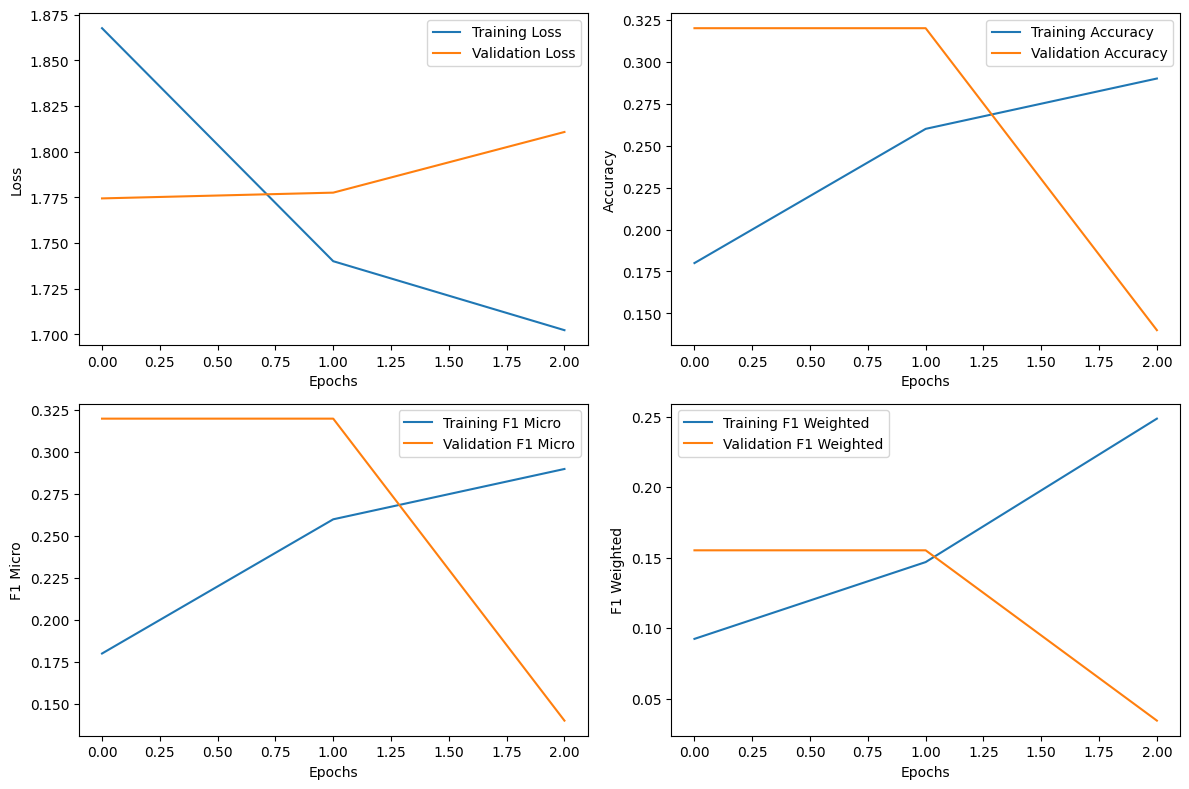



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Fold 2/3
Epoch 0/2
----------
Loss: 1.9079 Acc: 0.2600
F1 Micro: 0.2600 F1 Weighted: 0.1711
Precision: 0.2600 Recall: 0.2600
Confusion Matrix:
tensor([[22,  0,  0,  1,  1,  4,  0],
        [ 6,  0,  0,  0,  1,  0,  0],
        [ 5,  0,  0,  0,  0,  1,  0],
        [10,  0,  0,  2,  1,  1,  0],
        [18,  0,  0,  1,  1,  1,  0],
        [16,  0,  0,  1,  0,  1,  0],
        [ 6,  0,  0,  0,  0,  0,  0]])
Validation Loss: 1.7736 Acc: 0.2800
Validation F1 Micro: 0.2800 F1 Weighted: 0.1225
Validation Precision: 0.2800 Recall: 0.2800
Validation Confusion Matrix:
tensor([[14,  0,  0,  0,  0,  0,  0],
        [ 2,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0],
        [ 6,  0,  0,  0,  0,  0,  0],
        [13,  0,  0,  0,  0,  0,  0]

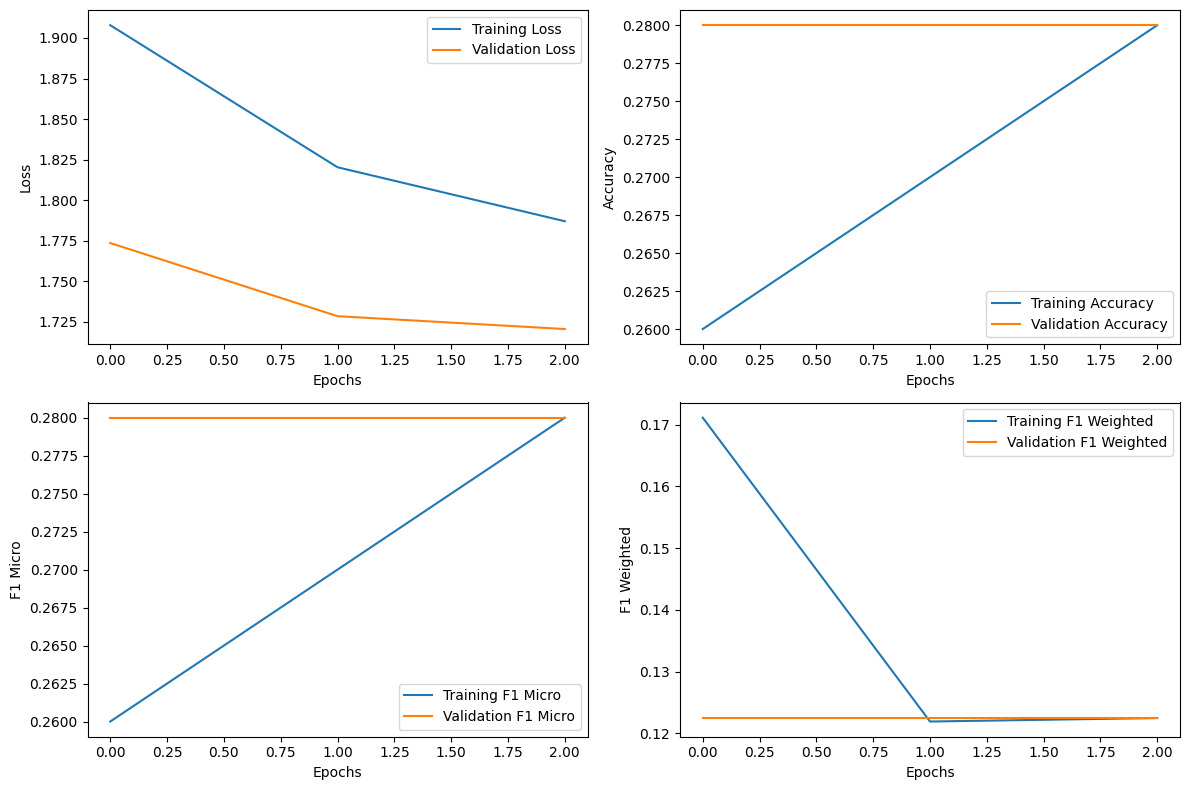



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Fold 3/3
Epoch 0/2
----------
Loss: 1.8520 Acc: 0.2100
F1 Micro: 0.2100 F1 Weighted: 0.1505
Precision: 0.2100 Recall: 0.2100
Confusion Matrix:
tensor([[ 0,  0,  0,  2, 12, 16,  0],
        [ 0,  1,  0,  1,  3,  1,  0],
        [ 1,  0,  0,  0,  0,  2,  0],
        [ 1,  0,  0,  0,  7,  3,  0],
        [ 2,  0,  0,  2, 14,  7,  0],
        [ 2,  0,  0,  0, 12,  6,  0],
        [ 0,  0,  0,  0,  5,  0,  0]])
Validation Loss: 1.8498 Acc: 0.1800
Validation F1 Micro: 0.1800 F1 Weighted: 0.0549
Validation Precision: 0.1800 Recall: 0.1800
Validation Confusion Matrix:
tensor([[ 0,  0,  0,  0, 12,  0,  0],
        [ 0,  0,  0,  0,  3,  0,  0],
        [ 0,  0,  0,  0,  3,  0,  0],
        [ 0,  0,  0,  0,  9,  0,  0],
        [ 0,  0,  0,  0,  9,  0,  0]

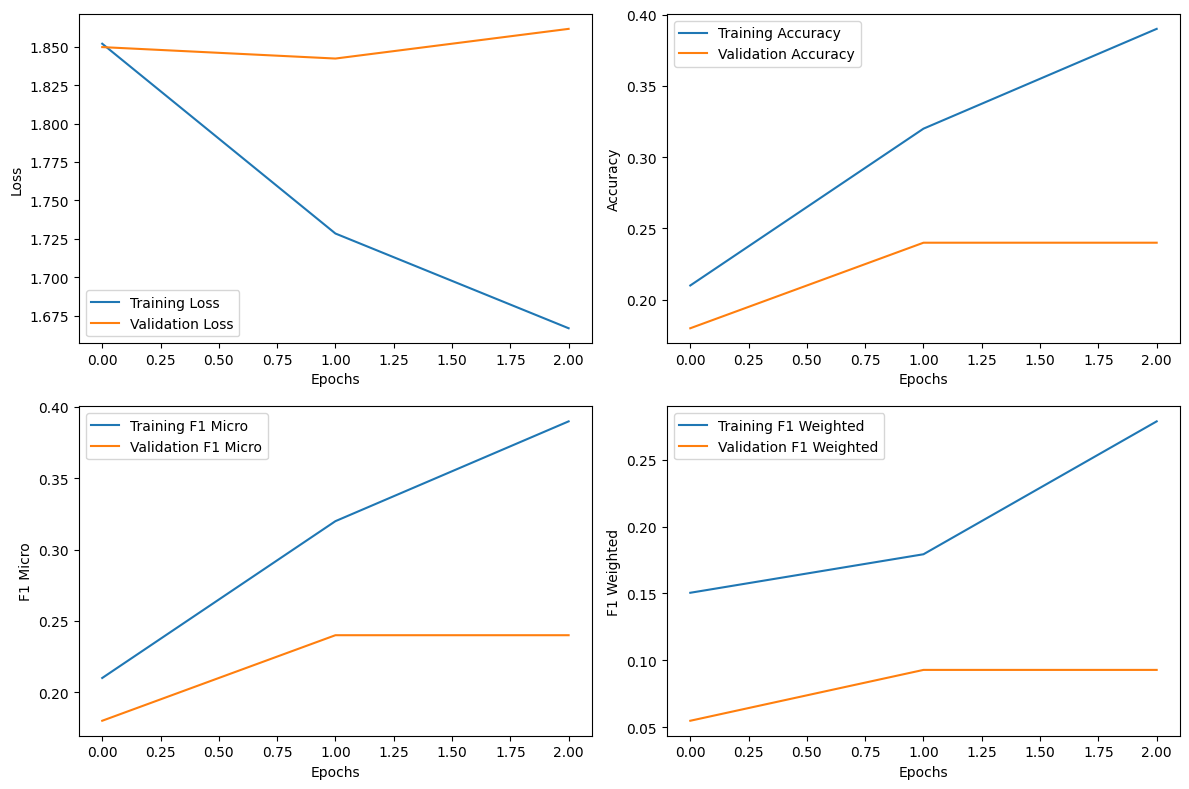

In [8]:
data_root = "Exercise4/timematch_data/denmark/32VNH/2017"
# Cross-validation

train_losses = []
train_accuracies = []
train_f1_micros = []
train_f1_weighteds = []
train_precisions = []
train_recalls = []

val_losses = []
val_accuracies = []
val_f1_micros = []
val_f1_weighteds = []
val_precisions = []
val_recalls = []

for i, (train_indices, val_indices) in enumerate(folds):
    print(80*"-")
    print(80*"-")
    print(80*"-")
    
    print(f"Fold {i+1}/{len(folds)}")
    
    train_loss, train_accuracy, train_f1_micro, train_f1_weighted, val_loss, val_accuracy,\
        val_f1_micro, val_f1_weighted, train_precision, train_recall, val_precision, val_recall = \
            train_one_fold(device, train_indices, val_indices, data_root,
                           class_to_idx, labels_200)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    train_f1_micros.append(train_f1_micro)
    train_f1_weighteds.append(train_f1_weighted)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_f1_micros.append(val_f1_micro)
    val_f1_weighteds.append(val_f1_weighted)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    
    print()
    print()

In [9]:
# print the means and stds of the metrics

print(f"Train Loss: {np.mean(np.array(train_losses))} +- {np.std(np.array(train_losses))}")
print(f"Train Accuracy: {np.mean(np.array(train_accuracies))} +- {np.std(np.array(train_accuracies))}")
print(f"Train F1 Micro: {np.mean(np.array(train_f1_micros))} +- {np.std(np.array(train_f1_micros))}")
print(f"Train F1 Weighted: {np.mean(np.array(train_f1_weighteds))} +- {np.std(np.array(train_f1_weighteds))}")
print(f"Train Precision: {np.mean(np.array(train_precisions))} +- {np.std(np.array(train_precisions))}")
print(f"Train Recall: {np.mean(np.array(train_recalls))} +- {np.std(np.array(train_recalls))}")
print()
print(f"Val Loss: {np.mean(np.array(val_losses))} +- {np.std(np.array(val_losses))}")
print(f"Val Accuracy: {np.mean(np.array(val_accuracies))} +- {np.std(np.array(val_accuracies))}")
print(f"Val F1 Micro: {np.mean(np.array(val_f1_micros))} +- {np.std(np.array(val_f1_micros))}")
print(f"Val F1 Weighted: {np.mean(np.array(val_f1_weighteds))} +- {np.std(np.array(val_f1_weighteds))}")
print(f"Val Precision: {np.mean(np.array(val_precisions))} +- {np.std(np.array(val_precisions))}")
print(f"Val Recall: {np.mean(np.array(val_recalls))} +- {np.std(np.array(val_recalls))}")

Train Loss: 1.718706334431966 +- 0.050472827611063996
Train Accuracy: 0.3199999928474426 +- 0.04966554272529947
Train F1 Micro: 0.3199999928474426 +- 0.04966554272529947
Train F1 Weighted: 0.21652986605962118 +- 0.06761169043565775
Train Precision: 0.3199999928474426 +- 0.04966554272529947
Train Recall: 0.3199999928474426 +- 0.04966554272529947

Val Loss: 1.7977138678232827 +- 0.05834118401310948
Val Accuracy: 0.2199999988079071 +- 0.05887840530309626
Val F1 Micro: 0.2199999988079071 +- 0.05887840530309626
Val F1 Weighted: 0.08326306442419688 +- 0.03661257045776466
Val Precision: 0.2199999988079071 +- 0.05887840530309626
Val Recall: 0.2199999988079071 +- 0.05887840530309626
